In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import numpy as np

df = pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\(GOV BONDS) Yield Curve Arbitrage\Data\Expected values of predictor variables (6 mo horizon - 31-12-2024)\Work\30-Year Breakeven Inflation Rate (%)\Data.csv")
name = "T30YIEM"
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.asfreq(pd.infer_freq(df.index))
last_value = df[name].iloc[-1]
df[name] = df[name].diff()
df=df.dropna()

result = adfuller(df[name])
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


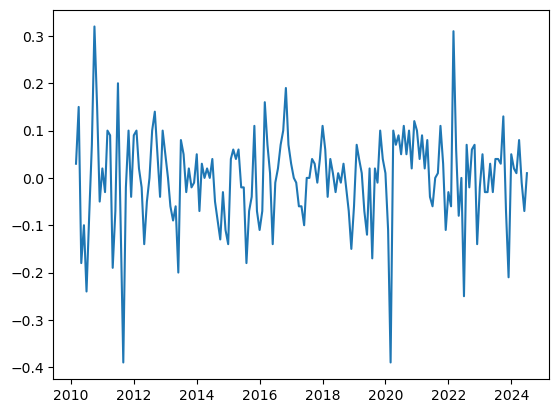

In [2]:
plt.plot(df)

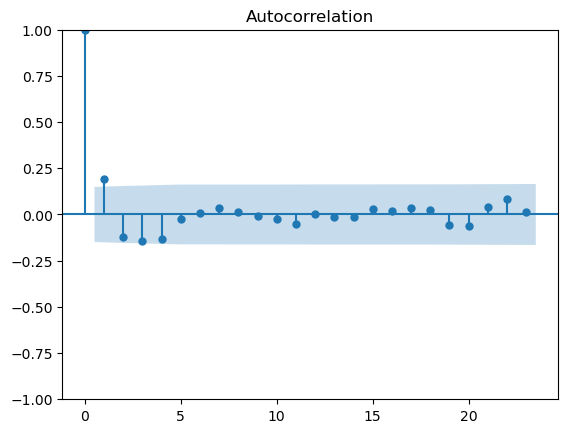

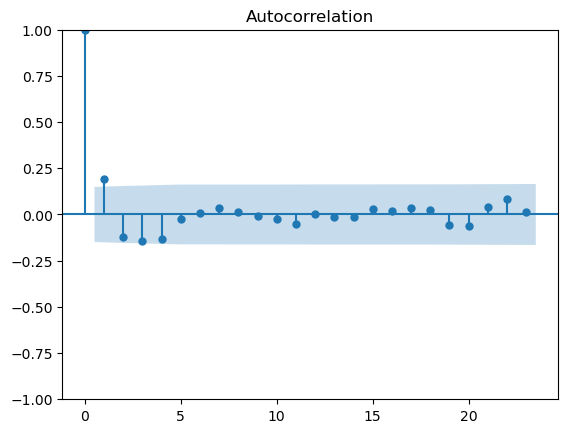

In [3]:
plot_acf(df[name])

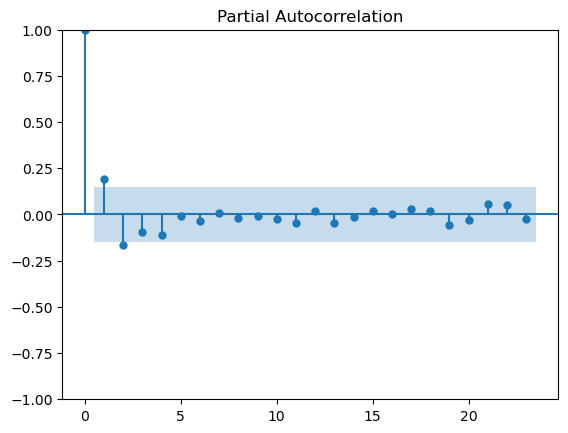

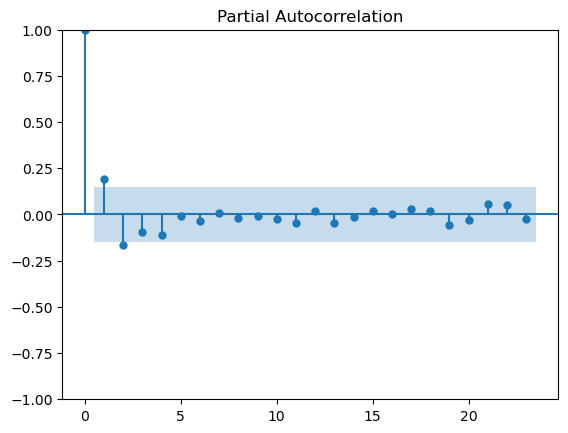

In [4]:
plot_pacf(df[name])

In [5]:
train_end = df.index[-6]

train_data = df[:train_end]
test_data = df[train_end:]

In [6]:
ar_orders = range(1,4)
ma_orders = range(1,4)
fitted_model_dict = {}

for ar_order in ar_orders:
    for ma_order in ma_orders:    

        arima_model = ARIMA(train_data, order=(ar_order,0,ma_order))
        arima_model_fit = arima_model.fit()
        fitted_model_dict[(ar_order, ma_order)] = arima_model_fit #this saves the model_fit to the right key like AR(1) to 1 AR(4) to 4

lowest_bic = float('inf')
best_order = None

for ar_order in ar_orders:
    for ma_order in ma_orders:
        bic_value = fitted_model_dict[(ar_order, ma_order)].bic #arima_model_fit.bic
        if bic_value < lowest_bic:
            lowest_bic = bic_value
            best_order = (ar_order, ma_order)

print(f'Lowest BIC: {lowest_bic} for AR({best_order[0]}) and MA({best_order[1]})')

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Lowest BIC: -286.9600923469956 for AR(1) and MA(1)


c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
model = ARIMA(train_data, order=(1,0,1))
model_fit = model.fit()

In [8]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                T30YIEM   No. Observations:                  168
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 153.728
Date:                Sun, 22 Sep 2024   AIC                           -299.456
Time:                        13:59:57   BIC                           -286.960
Sample:                    03-01-2010   HQIC                          -294.385
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.010     -0.138      0.890      -0.020       0.017
ar.L1         -0.2407      0.279     -0.864      0.388      -0.787       0.305
ma.L1          0.4687      0.262      1.787      0.0

In [9]:
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

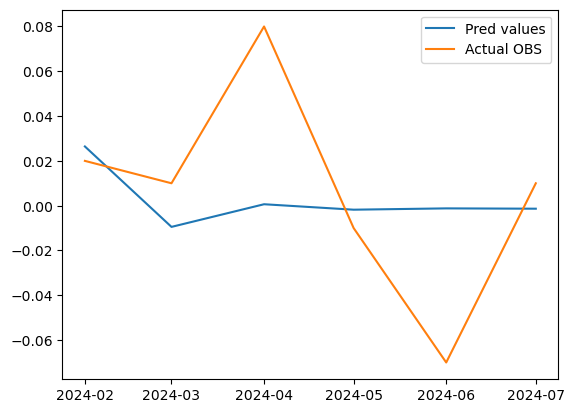

In [10]:
plt.plot(predictions, label = "Pred values")
plt.plot(test_data, label="Actual OBS")
plt.legend()

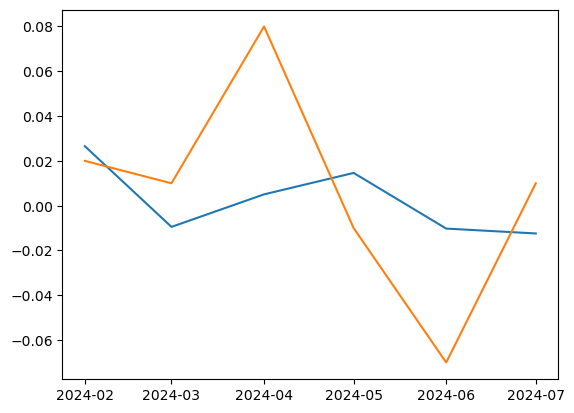

In [11]:
rolling_predictions = pd.Series(index=test_data.index) #initialise a series

for i in test_data.index:#give me the next week + timedelta(days=7)
    train_data = df[:i - DateOffset(months=1)]
    model = ARIMA(train_data, order=(1,0,1))
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions.loc[i] = pred

plt.plot(rolling_predictions, label='Pred values')
plt.plot(test_data, label='Actual OBS')

In [12]:
rolling_predictions = pd.DataFrame(rolling_predictions)
rolling_predictions.rename(columns={0: 'Predictions'}, inplace=True)
rolling_predictions

,Predictions
DATE,
2024-02-01,0.026533
2024-03-01,-0.009469
2024-04-01,0.005059
2024-05-01,0.014621
2024-06-01,-0.010224
2024-07-01,-0.012400


In [13]:
test_data

,T30YIEM
DATE,
2024-02-01,0.02
2024-03-01,0.01
2024-04-01,0.08
2024-05-01,-0.01
2024-06-01,-0.07
2024-07-01,0.01


In [14]:
residuals = test_data[name] - rolling_predictions['Predictions']
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.042266844693424725


c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

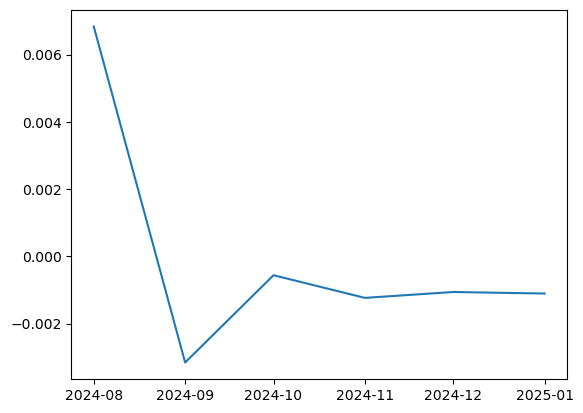

In [15]:
future_periods = 6  # e.g., predicting the next 6 months
future_dates = pd.date_range(start=df.index[-1] + DateOffset(months=1), periods=future_periods, freq='MS')
rolling_predictions = pd.Series(index=future_dates)

# Initialize the training data with the full df
train_data = df.copy()

# Iterate over each future period to make predictions
for i in range(future_periods):
    # Train the model on the current train_data
    model = ARIMA(train_data, order=(1, 0, 1))
    model_fit = model.fit()
    
    # Make the prediction for the next point
    pred = model_fit.forecast()
    
    # Determine the index of the new prediction
    next_index = train_data.index[-1] + DateOffset(months=1)
    
    # Append the prediction to the rolling_predictions and train_data
    rolling_predictions.loc[next_index] = pred
    train_data.loc[next_index] = pred  # this is adding the pred observation to the train data so as to consider it for the next prediction

plt.plot(rolling_predictions)


In [16]:
rolling_predictions

2024-08-01    0.006835
2024-09-01   -0.003158
2024-10-01   -0.000563
2024-11-01   -0.001237
2024-12-01   -0.001062
2025-01-01   -0.001108
Freq: MS, dtype: float64

In [17]:
df[name]

DATE
2010-03-01    0.03
2010-04-01    0.15
2010-05-01   -0.18
2010-06-01   -0.10
2010-07-01   -0.24
              ... 
2024-03-01    0.01
2024-04-01    0.08
2024-05-01   -0.01
2024-06-01   -0.07
2024-07-01    0.01
Freq: MS, Name: T30YIEM, Length: 173, dtype: float64

In [18]:
predictions = np.array(rolling_predictions)
original_values = [last_value]    
for i in predictions:
    new_value = original_values[-1] + i
    original_values.append(new_value)
    
the_actual_predictions_I_need = np.array(original_values[1:])
the_actual_predictions_I_need[-1]

2.2797065670625196